# 0. Применение метода KNN для решения задачи классификации

Набор данных получен в результате переписи населения 1994 года и содержит информацию о некотором количестве людей, проживающих в США. Задача состоит в том, чтобы предсказать, зарабатывает человек более $50к в год или нет. Список признаков:

*   <b>age</b>: возраст человека.
*   <b>workclass</b>: статус занятости.
*   <b>fnlwgt</b>: количество людей, которое, по мнению переписи, представляет запись.
*   <b>education</b>: высший уровень образования, достигнутый человеком.
*   <b>education-num</b>: высший уровень образования, достигнутый человеком в числовой форме.
*   <b>marital-status</b>: семейное положение человека.
*   <b>occupation</b>: общий род занятий человека.
*   <b>relationship</b>: представляет то, чем этот человек является по отношению к другим (перекликается с признаком <b>marital-status</b>).
*   <b>race</b>: раса.
*   <b>sex</b>: пол.
*   <b>capital-gain</b>: прирост капитала.
*   <b>capital-loss</b>: убыток капитала.
*   <b>hours-per-week</b>: число рабочих часов в неделю.
*   <b>native-country</b>: страна происхождения.
*   <b>the label</b>: отклик -- зарабатывает больше $50к или меньше.



## Немного про метрики качества модели

Для начала рассмотрим так называемую матрицу ошибок (confusion matrix)
-- способ разделить объекты на $4$ группы в зависимости от комбинации
истинного класса и ответа классификатора:

-   TP (True Positives) -- верно классифицированные объекты, исходно     относящиеся к классу "$+1$";

-   TN (True Negatives) -- верно классифицированные объекты, исходно     относящиеся к классу "$-1$";

-   FN (False Negatives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$+1$" (ошибка I рода);

-   FP (False Positives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$-1$" (ошибка II рода).

Обычно, конечно, оперируют не абсолютными показателями, а относительными
-- долями (rates), находящимися в диапазоне от $0$ до $1$:

-   доля правильных ответов классификатора (иногда -- точность): $$\mathsf{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}.$$ Эта величина показывает отношение количества верно классифицированных объектов к общему количеству классифицируемых объектов и, грубо говоря, оценивает вероятность случайному объекту быть правильно классифицированным.

-   доля истинно положительных примеров -- True Positives Rate (TPR) или     Sensitivity (чувствительность) или Recall: $$\mathsf{T P R}=\frac{T P}{T P+F N}.$$ Эта величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$+1$", к общему количеству объектов класса "$+1$". �?ными словами -- это оценка вероятности, что объект, относящийся к классу "$+1$" будет классифицирован корректно.

-   доля ложно положительных примеров обозначается как -- False Positives Rate (FPR): $$\mathsf{F P R}=\frac{F P}{FP + TN}.$$ Величина показывает отношение количества неверно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован неверно.

-   Специфичность (Specificity) или True Negatives Rate (TNR): $$\mathsf{TNR} = 1 - \mathsf{F P R} =\frac{T N}{T N+F P}.$$ Величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован верно.

-   Precision (точность): $$\mathsf{Precision} =\frac{TP}{TP + FP}.$$ Величина показывает, какая доля объектов, отнесенных классификатором к классу "$+1$", действительно относится к этому классу.

Естественно возникает вопрос, нет ли какого-то обобщающего критерия,
который может характеризовать качество построенной модели. Один из них --
так называемая $F$-мера ($F_1$-мера, $F$ score, $F_1$ score)
определяется следующим соотношением:
$$F = F_1 = 2 \cdot \frac{\mathsf{Precision} \cdot \mathsf{Recall}}{\mathsf{Precision} + \mathsf{Recall}}.$$

**Замечание**. *$F$-мера является средним гармоническим величин
$\mathsf{Precision}$ и $\mathsf{Recall}$ и заключена в диапазоне
$[0, 1]$. Среднее гармоническое обладает важным свойством: оно близко к
нулю, если хотя бы один из аргументов близок к нулю. Поэтому оно является
куда более предпочтительным, чем, скажем, среднее арифметическое: если
алгоритм относит все объекты к положительному классу, то
$\mathsf{Recall}= 1$, а $\mathsf{Precision}$, скорее всего, будет
небольшим. Но тогда среднее арифметическое будет больше, чем $0.5$, что,
конечно, никуда не годится.*

## Импорт библиотек и чтение набора данных

In [229]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot as plt

Считайте набор данных в датафрейм. Исходя из описания признаков можно сразу избавиться от признаков <code>education</code> и <code>marital-status</code>. Удалите соответствующие колонки из набора данных.

In [230]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [231]:
df = pd.read_csv("/content/drive/MyDrive/DeepLearningCourse/adult_data_train.csv")
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,?,122244,HS-grad,9,Never-married,?,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,Some-college,10,Divorced,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,HS-grad,9,Never-married,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,Some-college,10,Divorced,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


In [232]:
df = df.replace('?', np.nan).drop(['education','marital-status'], axis=1)
df

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,NaN,122244,9,NaN,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,9,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,10,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,9,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,13,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


Определите количество числовых и нечисловых признаков.

In [233]:
print('Количество числовых признаков: ', df.select_dtypes(include=['int64']).shape[1])
print('Количество нечисловых признаков: ', df.select_dtypes(exclude=['int64']).shape[1])

Количество числовых признаков:  7
Количество нечисловых признаков:  6


Постройте гистограмму распределения объектов по классам. Вычислите долю объектов класса $0$.

<ipython-input-234-9c37c2bd8ad1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


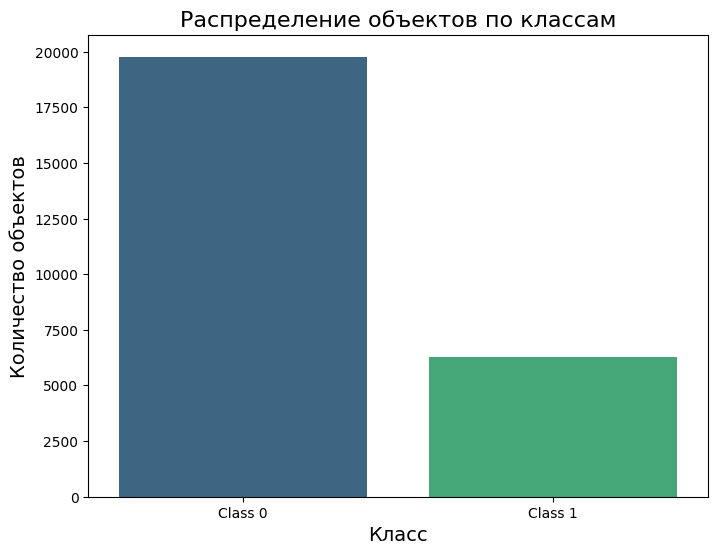

In [234]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Распределение объектов по классам', fontsize=16)
plt.xlabel('Класс', fontsize=14)
plt.ylabel('Количество объектов', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
plt.show()

# 1. Построение базовой модели

В качестве первого приближения имеет смысл построить модель классификации, опираясь исключительно на числовые признаки.

Отберите из набора данных только числовые признаки. При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки <b>с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>label</code>.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных.

Обучите модель <code>KNeighborsClassifier()</code> с параметрами по умолчанию на тренировочных данных.

Как видно из предыдущего пункта, в наборе данных наблюдается явный дисбаланс представителей классов. Это следует учесть при оценке модели. Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.

В качестве альтернативы можно использовать так называемый <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html"><code>classification_report()</code></a>, где приведены сразу несколько метрик (не стоит забывать про параметр <code>digits</code>).

In [235]:
df_nums = df.select_dtypes(include=['int64'])
df_nums

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label
0,32,37210,13,0,0,45,1
1,43,101950,14,0,0,45,0
2,20,122244,9,0,0,28,0
3,40,24763,10,6849,0,40,0
4,24,113936,13,0,0,40,0
...,...,...,...,...,...,...,...
26043,35,179171,9,0,0,38,0
26044,39,421633,10,0,0,30,0
26045,55,82098,9,0,0,55,0
26046,26,50053,13,0,0,55,0


In [236]:
def build_model(df):
  X, y = df.drop('label', axis=1), df['label']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)
  knn = KNeighborsClassifier().fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  f_1_score = f1_score(y_test, y_pred)
  return X_train.fnlwgt.mean(), f_1_score, classification_report(y_test, y_pred, digits = 3)

mean, score, report = build_model(df_nums)
print('Выборочноее среднее столбца fnlwgt: ', round(mean, 3))
print('F_1(weighted) модели: ', round(score, 3))
print('Отчет о классификации: \n', report)

Выборочноее среднее столбца fnlwgt:  190021.844
F_1(weighted) модели:  0.388
Отчет о классификации: 
               precision    recall  f1-score   support

           0      0.806     0.929     0.863      3955
           1      0.569     0.294     0.388      1255

    accuracy                          0.776      5210
   macro avg      0.687     0.612     0.625      5210
weighted avg      0.749     0.776     0.749      5210



Стоит помнить, что KNN является метрическим классификатором, поэтому значения признаков перед обучением модели следует нормировать.

Обучите преобразование <code>MinMaxScaler()</code> на тренировочном наборе данных и примените его для тренировочных и тестовых данных.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных после нормировки.

Заново обучите и оцените модель на преобразованных данных. Вычислите <code>f1_score()</code> модели.

In [237]:
def build_model(df):
  X, y = df.drop('label', axis=1), df['label']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)
  scaler = MinMaxScaler().fit(X_train)
  X_train_scaled = scaler.transform(X_train)
  #!!! ВАЖНО. Скейлер не надо обучать повторно. Просто применяем к тестовым данным
  X_test_scaled = scaler.transform(X_test)
  knn = KNeighborsClassifier().fit(X_train_scaled, y_train)
  y_pred = knn.predict(X_test_scaled)
  f_1_score = f1_score(y_test, y_pred)
  return X_train_scaled[:,1].mean(), f_1_score

mean, score = build_model(df_nums)
print('Выборочноее среднее столбца fnlwgt: ', round(mean, 3))
print('F_1(weighted) модели: ', round(score, 3))

Выборочноее среднее столбца fnlwgt:  0.121
F_1(weighted) модели:  0.518


Видно, что после линейной нормировки качество выросло.

<b>Важно: </b>На дальнейших этапах подразумевается использование линейной нормировки непосредственно перед обучением без дополнительных напоминаний.

# 2. Работа с нечисловыми признаками

## Визуализация

Для дальнейшего улучшения качества модели имеет смысл задействовать нечисловые признаки исходного датасета (без колонок <code>education</code> и <code>marital-status</code>).

Постройте гистограммы, иллюстрирующие частоту того или иного значения по каждому нечисловому признаку, например, при помощи <code>sns.barplot()</code>.

<ipython-input-238-03c4b80f01c7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


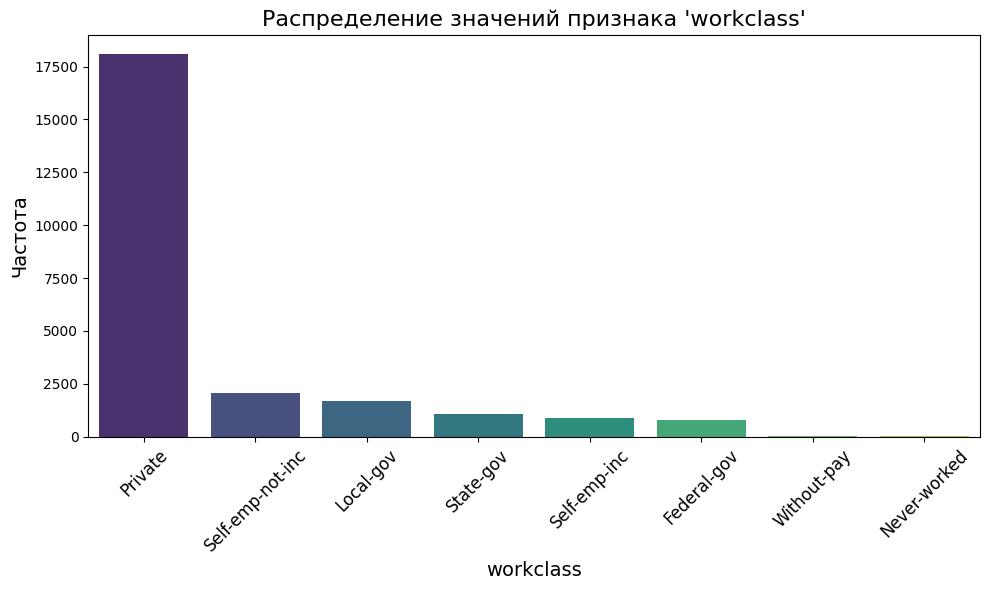

<ipython-input-238-03c4b80f01c7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


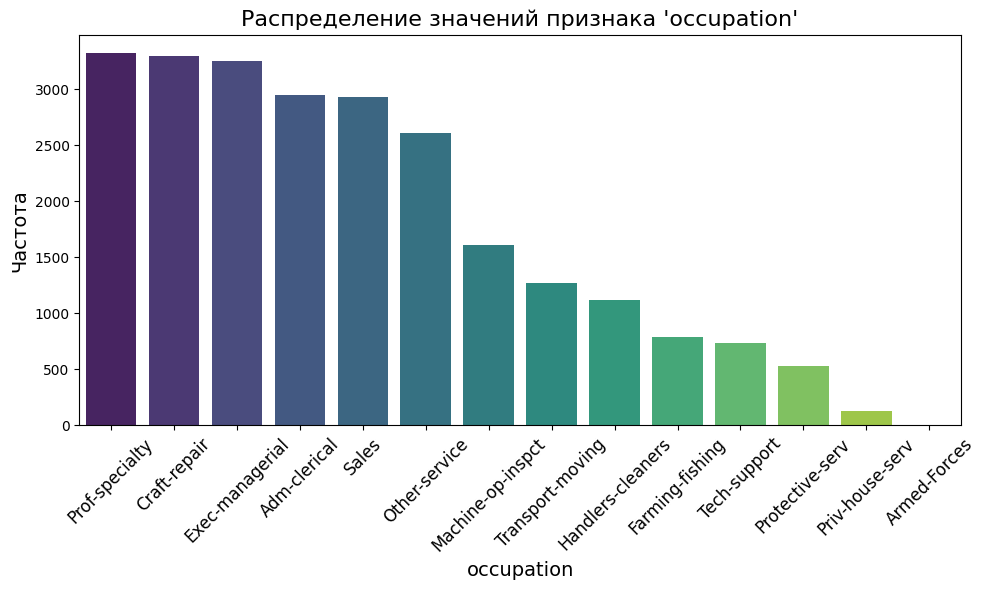

<ipython-input-238-03c4b80f01c7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


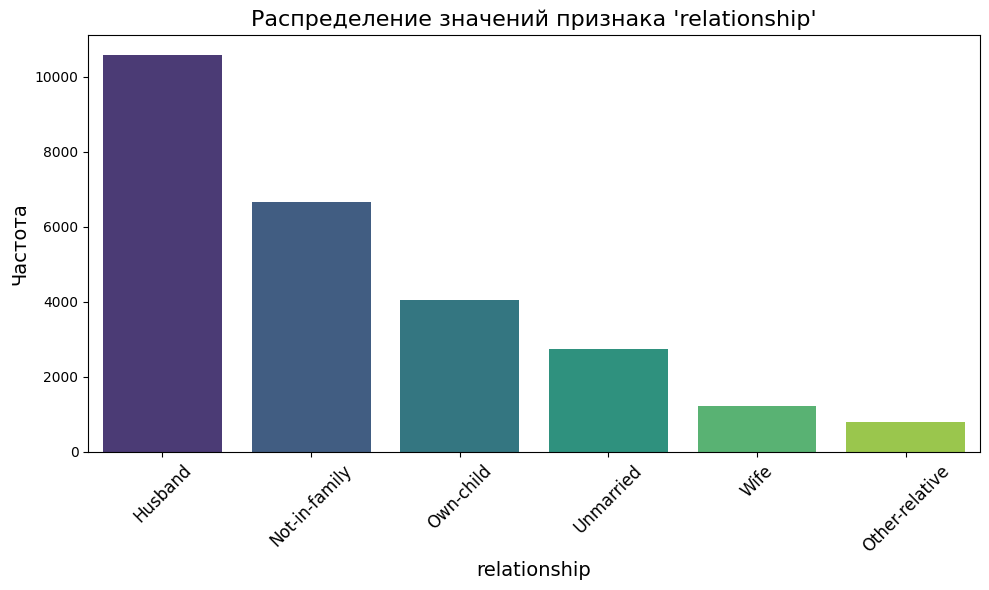

<ipython-input-238-03c4b80f01c7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


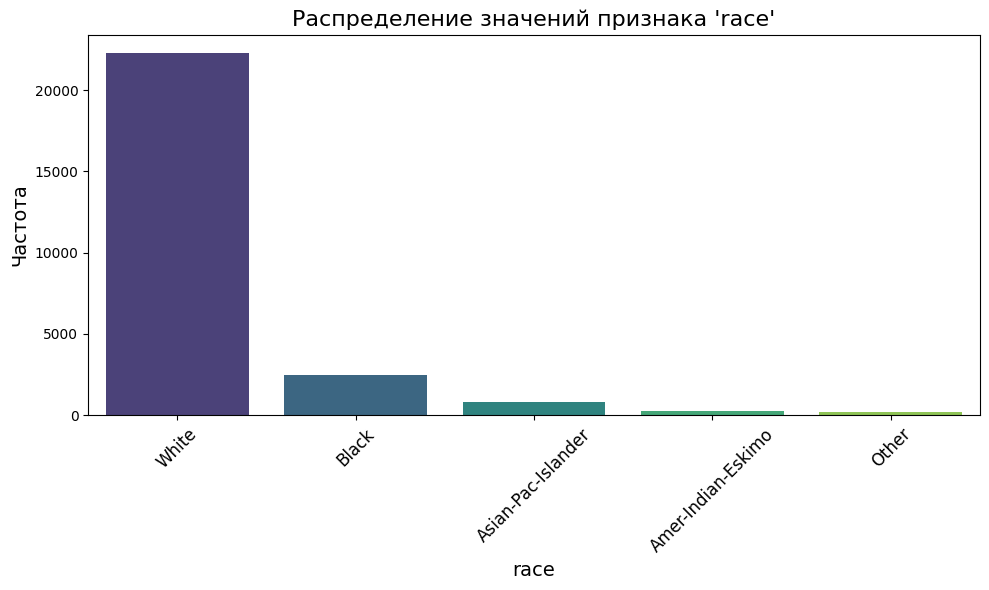

<ipython-input-238-03c4b80f01c7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


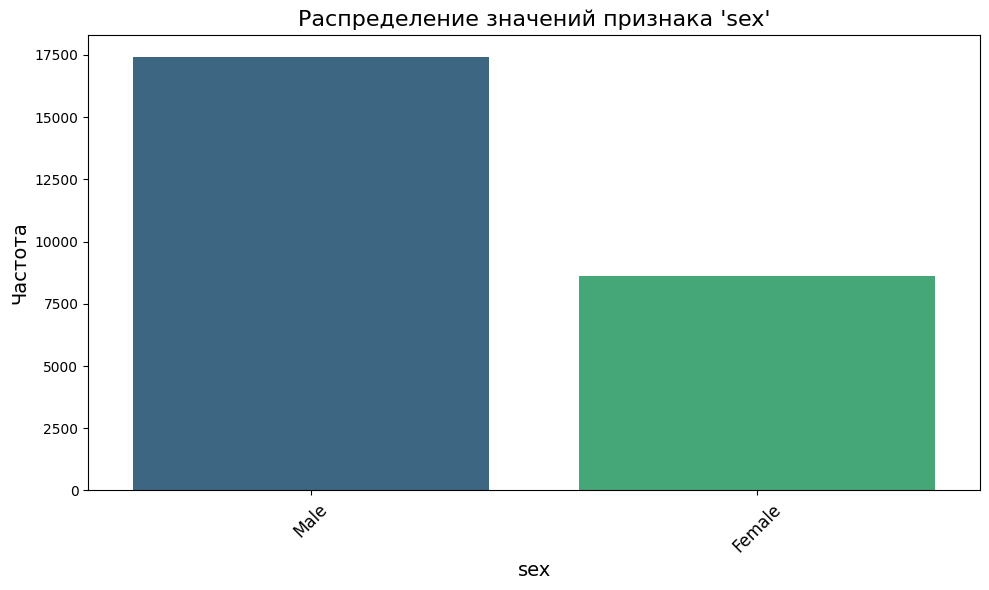

<ipython-input-238-03c4b80f01c7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


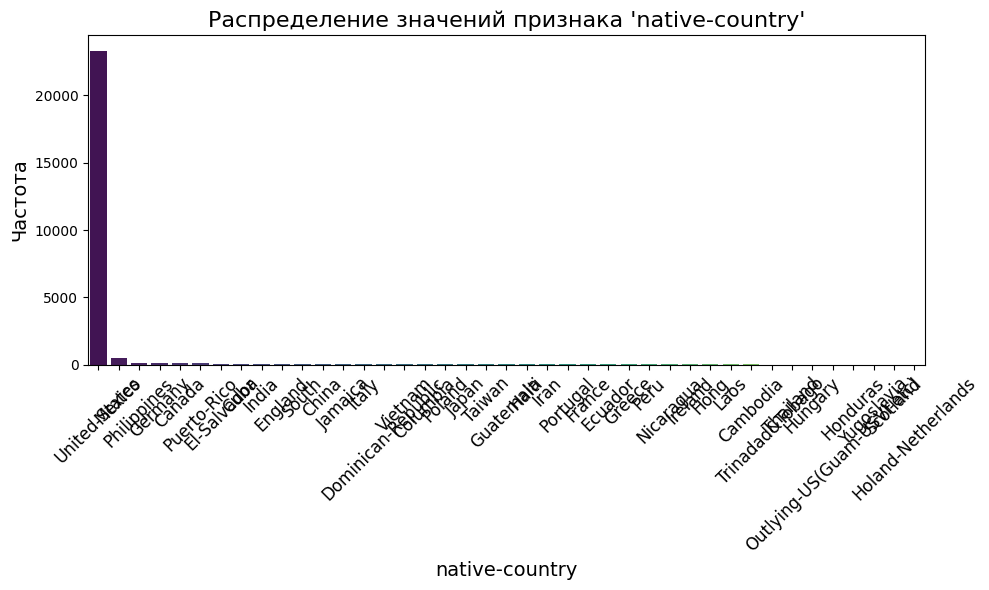

In [238]:
categorical_features = df.select_dtypes(include=['object']).columns

# Построение гистограмм для каждого нечислового признака
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x = df[feature].value_counts().index,
        y = df[feature].value_counts().values,
        palette="viridis"
    )
    plt.title(f"Распределение значений признака '{feature}'", fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel("Частота", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()

## Удаление пропущенных значений

Определите число строк исходного набора данных (без колонок <code>education</code> и <code>marital-status</code>), в которых присутствует хотя бы одно пропущенное значение.

In [239]:
df.isnull().values.any()

True

In [240]:
df_drop_nans = df.dropna()
print('Число строк содержащих хоть один пропуск: ', len(df) - len(df_drop_nans))

Число строк содержащих хоть один пропуск:  1914


Видно, что в датасете содержится менее 10% строк, содержащих пропуски. Выкидывать такое количество строк — не очень хорошее дело, но почему бы не попробовать обойтись без них.

Удалите строки, содеражащие пропуски. Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>.

Введите число полученных признаков.

In [241]:
df_drop_nans_dummies = pd.get_dummies(df_drop_nans, drop_first=True)
print('Число полученных признаков: ', df_drop_nans_dummies.shape[1]-1)
df_drop_nans_dummies

Число полученных признаков:  75


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,32,37210,13,0,0,45,1,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,43,101950,14,0,0,45,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,40,24763,10,6849,0,40,0,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,24,113936,13,0,0,40,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
5,51,237630,9,7298,0,50,1,False,True,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,179171,9,0,0,38,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26044,39,421633,10,0,0,30,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
26045,55,82098,9,0,0,55,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
26046,26,50053,13,0,0,55,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False


Обучите модель классификации аналогично тому, как это было проделано для базовой модели. Вычислите <code>f1_score()</code> модели.



In [242]:
mean, score = build_model(df_drop_nans_dummies)
print('F_1(weighted) модели: ', round(score, 3))

F_1(weighted) модели:  0.61


Точность модели увеличилась по сравнению с моделью, которая использовала только числовые признаки.

## Заполнение пропущенных значений

Возможно точность еще повысится, если задействовать строки с пропущенными значениями.Используя исходный датасет (без колонок <code>education</code> и <code>marital-status</code>), заполните пропуски самым часто встречающимся значением в рамках столбца.

In [243]:
df2 = pd.read_csv("/content/drive/MyDrive/DeepLearningCourse/adult_data_train.csv").replace('?', np.nan)
df2

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,NaN,122244,HS-grad,9,Never-married,NaN,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,Some-college,10,Divorced,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,HS-grad,9,Never-married,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,Some-college,10,Divorced,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


In [244]:
df2.fillna(df2.mode().iloc[0])

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,Private,122244,HS-grad,9,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,Some-college,10,Divorced,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,HS-grad,9,Never-married,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,Some-college,10,Divorced,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


In [245]:
df2

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,NaN,122244,HS-grad,9,Never-married,NaN,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,Some-college,10,Divorced,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,HS-grad,9,Never-married,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,Some-college,10,Divorced,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


In [246]:
df2_dummies = pd.get_dummies(df2, drop_first=True)
df2_dummies

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,32,37210,13,0,0,45,1,False,False,True,...,False,False,False,False,False,False,False,True,False,False
1,43,101950,14,0,0,45,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,20,122244,9,0,0,28,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,40,24763,10,6849,0,40,0,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,24,113936,13,0,0,40,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,179171,9,0,0,38,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26044,39,421633,10,0,0,30,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
26045,55,82098,9,0,0,55,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
26046,26,50053,13,0,0,55,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False


Далее по уже знакомому сценарию: <code>one-hot</code>, <code>split</code>, <code>scaling</code>, обучение и оценка.

Вычислите <code>f1_score()</code> модели.

In [247]:
mean, score = build_model(df2_dummies)
print('F_1(weighted) модели: ', round(score, 3))

F_1(weighted) модели:  0.6


## Проклятие размерности

В последнем пункте был получен набор данных, содержащий 76 признаков (кстати, попробуйте объяснить, почему в случае удаления строк число признаков в итоге оказалось равным 75), что является достаточным для того, чтобы столкнуться с так называемым проклятием размерности.

Для того, чтобы классификатор давал более качественные результаты, имеет смысл более внимательно и вдумчиво поработать с признаками с учетом проклятия размерности. Например, вернуть в рассмотрение признаки <code>education-num</code> и <code>marital-status</code>. А также более глубоко вникнуть в саму природу признаков.

In [396]:
df_train = pd.read_csv("/content/drive/MyDrive/DeepLearningCourse/adult_data_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/DeepLearningCourse/adult_data_reserved.csv")
df_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,31,Self-emp-inc,117963,Doctorate,16,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States
1,20,?,201490,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States
2,78,Self-emp-inc,385242,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,9386,0,45,United-States
3,32,Private,164197,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,44,United-States
4,61,Private,92691,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,3,United-States


In [397]:
df_train = df_train.drop(['education', 'marital-status'], axis = 1)
df_test = df_test.drop(['education', 'marital-status'], axis = 1)

In [398]:
X_test = df_test.replace('?', np.nan)
X_test = X_test.fillna(X_test.mode().iloc[0])

X_test = pd.get_dummies(X_test, drop_first=True)
print('Число полученных признаков: ', X_test.shape[1]-1)

Число полученных признаков:  74


In [399]:
y_train = df_train['label']
X_train = df_train.drop('label', axis=1)

X_train = X_train.replace('?', np.nan)
X_train = X_train.fillna(X_train.mode().iloc[0])

X_train = pd.get_dummies(X_train, drop_first=True)
X_train = X_train.drop('native-country_Holand-Netherlands', axis=1)
print('Число полученных признаков: ', X_train.shape[1]-1)

Число полученных признаков:  74


In [400]:
def build_model(y_train, X_train, df_test):
  scaler = MinMaxScaler().fit(X_train)
  X_train_scaled = scaler.transform(X_train)
  X_test_scaled = scaler.transform(df_test)
  knn = KNeighborsClassifier().fit(X_train_scaled, y_train)
  y_pred = knn.predict(X_test_scaled)
  return y_pred

In [402]:
y_pred = build_model(y_train, X_train, X_test)

In [403]:
len(y_pred)

6513

In [404]:
print(list(y_pred))

[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 